# SnV117 Energy Structure

Plot ground and excited state energy levels vs magnetic field.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hamiltonian_qutip as ham
import parameters_qutip as params
%matplotlib inline


# Sweep B field intensity at a certain direction

In [2]:
# Parameters
# Magnetic field in Tesla
B_Tesla = np.linspace(0, 0.05, 200)  # [Tesla] Magnetic field sweep

# Conversion factor: g_e * mu_B in GHz/T
# mu_B = 13.996 GHz/T (Bohr magneton in frequency units)
# g_e ≈ 2 for electron
mu_B_GHz_per_T = 13.996  # [GHz/T]
g_e = 2.0

# Convert B from Tesla to GHz
B = g_e * mu_B_GHz_per_T * B_Tesla  # [GHz]

# B field direction (spherical coordinates)
theta = 0  # polar angle from z-axis [radians]
phi = 0    # azimuthal angle in xy-plane [radians]

# Strain parameters
alpha = 400  # [GHz] strain Ex
beta = 0   # [GHz] strain Ey

# Solve ground state (capture eigenstates for spin labeling)
E_gnd, Eref_gnd, _, U_states_gnd, _ = ham.solve_hamiltonian(
    B, theta, phi,
    params.q, params.Aperp_gnd, params.Apar_gnd, params.L, alpha, beta
)

# Solve excited state  
E_exc, Eref_exc, _, U_states_exc, _ = ham.solve_hamiltonian(
    B, theta, phi,
    params.q_exc, params.Aperp_exc, params.Apar_exc, params.L_exc, alpha, beta
)

# Define spin operators for labeling
# Tensor structure: orbital ⊗ electron ⊗ nuclear
import qutip as qt
S = params.S
Sn = params.Sn
I_orb = qt.qeye(2)  # orbital
I_e = qt.qeye(int(2*S + 1))  # electron
I_n = qt.qeye(int(2*Sn + 1))  # nuclear

# Spin z-components
Sz_e = qt.tensor(I_orb, qt.jmat(S, 'z'), I_n)  # electron spin z
Iz_n = qt.tensor(I_orb, I_e, qt.jmat(Sn, 'z'))  # nuclear spin z

# Total spin Fz = Sz + Iz
Fz = Sz_e + Iz_n

# Total spin squared F² = (S + I)² = S² + I² + 2*S·I
Sx_e = qt.tensor(I_orb, qt.jmat(S, 'x'), I_n)
Sy_e = qt.tensor(I_orb, qt.jmat(S, 'y'), I_n)
Ix_n = qt.tensor(I_orb, I_e, qt.jmat(Sn, 'x'))
Iy_n = qt.tensor(I_orb, I_e, qt.jmat(Sn, 'y'))

# F² = S(S+1) + I(I+1) + 2*(Sx*Ix + Sy*Iy + Sz*Iz)
F2 = (S*(S+1) + Sn*(Sn+1)) * qt.tensor(I_orb, I_e, I_n) + \
     2 * (Sx_e*Ix_n + Sy_e*Iy_n + Sz_e*Iz_n)

print(f"B field: {len(B)} points from 0 to {B_Tesla[-1]} T ({B[-1]:.2f} GHz)")
print(f"theta = {theta:.4f} rad, phi = {phi:.4f} rad")
print(f"E_gnd shape: {E_gnd.shape}")


B field: 200 points from 0 to 0.05 T (1.40 GHz)
theta = 0.0000 rad, phi = 0.0000 rad
E_gnd shape: (200, 8)


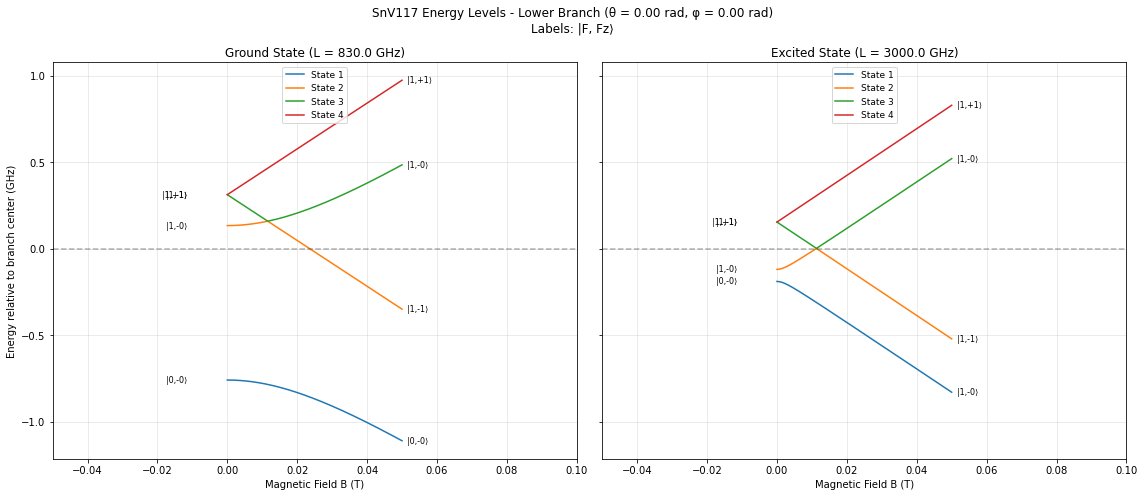

Ground state branch center: -576.390 GHz
Excited state branch center: -1552.417 GHz

Spin labels |F, Fz⟩ at B=0:
  Ground: ['|0,-0⟩', '|1,-0⟩', '|1,+1⟩', '|1,-1⟩']
  Excited: ['|0,-0⟩', '|1,-0⟩', '|1,+1⟩', '|1,-1⟩']

Spin labels |F, Fz⟩ at B=0.05 T:
  Ground: ['|0,-0⟩', '|1,-1⟩', '|1,-0⟩', '|1,+1⟩']
  Excited: ['|1,-0⟩', '|1,-1⟩', '|1,-0⟩', '|1,+1⟩']


In [3]:
# Plot ground and excited state energy levels side by side
# Select 4 lowest states (lower orbital branch) for each
lower_gnd_indices = np.argsort(E_gnd[0, :])[:4]  # 4 lowest energy states at B=0
lower_exc_indices = np.argsort(E_exc[0, :])[:4]  # 4 lowest energy states at B=0

# Extract the lower branch energies
E_gnd_lower = E_gnd[:, lower_gnd_indices]
E_exc_lower = E_exc[:, lower_exc_indices]

# Center at the branch center frequency (mean of the 4 states at B=0)
gnd_center = np.mean(E_gnd_lower[0, :])
exc_center = np.mean(E_exc_lower[0, :])

E_gnd_centered = E_gnd_lower - gnd_center
E_exc_centered = E_exc_lower - exc_center

# Calculate |F, Fz> labels at B=0 (index 0) and B=max (index -1)
# F is the total spin quantum number, Fz is the z-projection
def get_spin_labels(U_states, indices, b_idx):
    """Get |F, Fz> labels for states at a given B index."""
    labels = []
    for state_idx in indices:
        psi = U_states[b_idx][state_idx]
        # Calculate F from F² = F(F+1) => F = (-1 + sqrt(1 + 4*F²)) / 2
        f2_exp = qt.expect(F2, psi)
        F_val = (-1 + np.sqrt(1 + 4*f2_exp)) / 2
        # Calculate Fz = Sz + Iz
        fz_exp = qt.expect(Fz, psi)
        labels.append(f"|{F_val:.0f},{fz_exp:+.0f}⟩")
    return labels

# Get labels at B=0 and B=max for ground and excited states
labels_gnd_start = get_spin_labels(U_states_gnd, lower_gnd_indices, 0)
labels_gnd_end = get_spin_labels(U_states_gnd, lower_gnd_indices, -1)
labels_exc_start = get_spin_labels(U_states_exc, lower_exc_indices, 0)
labels_exc_end = get_spin_labels(U_states_exc, lower_exc_indices, -1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

# Ground state plot (centered)
for i in range(4):
    ax1.plot(B_Tesla, E_gnd_centered[:, i], '-', linewidth=1.5, label=f'State {lower_gnd_indices[i]+1}')
    # Add spin labels at start (B=0)
    ax1.annotate(labels_gnd_start[i], xy=(B_Tesla[0], E_gnd_centered[0, i]), 
                 xytext=(-40, 0), textcoords='offset points', fontsize=8, ha='right', va='center')
    # Add spin labels at end (B=max)
    ax1.annotate(labels_gnd_end[i], xy=(B_Tesla[-1], E_gnd_centered[-1, i]), 
                 xytext=(5, 0), textcoords='offset points', fontsize=8, ha='left', va='center')
ax1.set_xlabel('Magnetic Field B (T)')
ax1.set_ylabel('Energy relative to branch center (GHz)')
ax1.set_title(f'Ground State (L = {params.L} GHz)')
ax1.legend(loc='upper center', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax1.set_xlim(-0.05, B_Tesla[-1] + 0.05)  # Extra margin for labels

# Excited state plot (centered)
for i in range(4):
    ax2.plot(B_Tesla, E_exc_centered[:, i], '-', linewidth=1.5, label=f'State {lower_exc_indices[i]+1}')
    # Add spin labels at start (B=0)
    ax2.annotate(labels_exc_start[i], xy=(B_Tesla[0], E_exc_centered[0, i]), 
                 xytext=(-40, 0), textcoords='offset points', fontsize=8, ha='right', va='center')
    # Add spin labels at end (B=max)
    ax2.annotate(labels_exc_end[i], xy=(B_Tesla[-1], E_exc_centered[-1, i]), 
                 xytext=(5, 0), textcoords='offset points', fontsize=8, ha='left', va='center')
ax2.set_xlabel('Magnetic Field B (T)')
ax2.set_title(f'Excited State (L = {params.L_exc} GHz)')
ax2.legend(loc='upper center', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax2.set_xlim(-0.05, B_Tesla[-1] + 0.05)  # Extra margin for labels

fig.suptitle(f'SnV117 Energy Levels - Lower Branch (θ = {theta:.2f} rad, φ = {phi:.2f} rad)\nLabels: |F, Fz⟩', fontsize=12)
plt.tight_layout()
plt.show()

print(f"Ground state branch center: {gnd_center:.3f} GHz")
print(f"Excited state branch center: {exc_center:.3f} GHz")
print(f"\nSpin labels |F, Fz⟩ at B=0:")
print(f"  Ground: {labels_gnd_start}")
print(f"  Excited: {labels_exc_start}")
print(f"\nSpin labels |F, Fz⟩ at B={B_Tesla[-1]} T:")
print(f"  Ground: {labels_gnd_end}")
print(f"  Excited: {labels_exc_end}")


# Sweep B field direction with a fixed intensity

In [4]:
# Theta sweep at fixed B field
# Parameters
B_fixed_Tesla = 0.3  # [Tesla] Fixed magnetic field
B_fixed = g_e * mu_B_GHz_per_T * B_fixed_Tesla  # [GHz]

# Sweep theta from 0 to 2*pi
thetas = np.linspace(0, 2*np.pi, 200)
phi_fixed = np.pi/4  # arbitrary fixed phi

# Strain parameters (same as above)
alpha_theta = alpha
beta_theta = beta

# Arrays to store energies and eigenstates at endpoints
E_gnd_theta = np.zeros((len(thetas), 8))
E_exc_theta = np.zeros((len(thetas), 8))
U_states_gnd_theta_start = None
U_states_gnd_theta_end = None
U_states_exc_theta_start = None
U_states_exc_theta_end = None

# Solve for each theta
for i, th in enumerate(thetas):
    E_gnd_theta[i, :], _, _, U_gnd, _ = ham.solve_hamiltonian(
        np.array([B_fixed]), th, phi_fixed,
        params.q, params.Aperp_gnd, params.Apar_gnd, params.L, alpha_theta, beta_theta
    )
    E_exc_theta[i, :], _, _, U_exc, _ = ham.solve_hamiltonian(
        np.array([B_fixed]), th, phi_fixed,
        params.q_exc, params.Aperp_exc, params.Apar_exc, params.L_exc, alpha_theta, beta_theta
    )
    # Store eigenstates at start and end
    if i == 0:
        U_states_gnd_theta_start = U_gnd[0]
        U_states_exc_theta_start = U_exc[0]
    if i == len(thetas) - 1:
        U_states_gnd_theta_end = U_gnd[0]
        U_states_exc_theta_end = U_exc[0]

print(f"Theta sweep: {len(thetas)} points from 0 to 2π")
print(f"B = {B_fixed_Tesla} T ({B_fixed:.2f} GHz), φ = {phi_fixed:.4f} rad")


Theta sweep: 200 points from 0 to 2π
B = 0.3 T (8.40 GHz), φ = 0.7854 rad


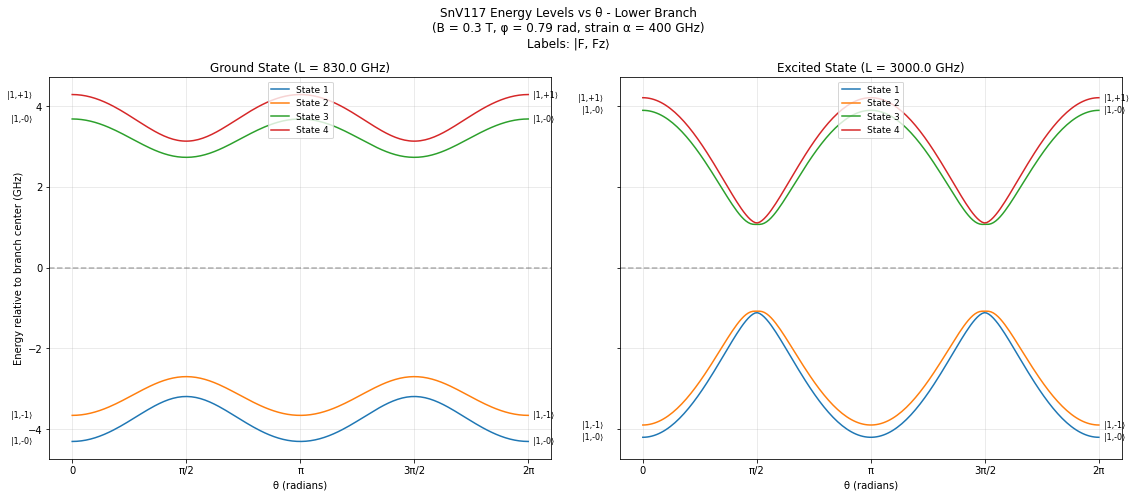

Ground state branch center: -576.390 GHz
Excited state branch center: -1552.417 GHz

Spin labels |F, Fz⟩ at θ=0:
  Ground: ['|1,-0⟩', '|1,-1⟩', '|1,-0⟩', '|1,+1⟩']
  Excited: ['|1,-0⟩', '|1,-1⟩', '|1,-0⟩', '|1,+1⟩']

Spin labels |F, Fz⟩ at θ=2π:
  Ground: ['|1,-0⟩', '|1,-1⟩', '|1,-0⟩', '|1,+1⟩']
  Excited: ['|1,-0⟩', '|1,-1⟩', '|1,-0⟩', '|1,+1⟩']


In [5]:
# Plot theta sweep - ground and excited states side by side
# Select 4 lowest states (lower orbital branch) for each at theta=0
lower_gnd_indices_theta = np.argsort(E_gnd_theta[0, :])[:4]
lower_exc_indices_theta = np.argsort(E_exc_theta[0, :])[:4]

# Extract the lower branch energies
E_gnd_lower_theta = E_gnd_theta[:, lower_gnd_indices_theta]
E_exc_lower_theta = E_exc_theta[:, lower_exc_indices_theta]

# Center at the branch center frequency (mean of the 4 states at theta=0)
gnd_center_theta = np.mean(E_gnd_lower_theta[0, :])
exc_center_theta = np.mean(E_exc_lower_theta[0, :])

E_gnd_centered_theta = E_gnd_lower_theta - gnd_center_theta
E_exc_centered_theta = E_exc_lower_theta - exc_center_theta

# Calculate |F, Fz> labels at theta=0 and theta=2pi
def get_spin_labels_theta(U_states, indices):
    """Get |F, Fz> labels for states."""
    labels = []
    for state_idx in indices:
        psi = U_states[state_idx]
        # Calculate F from F² = F(F+1) => F = (-1 + sqrt(1 + 4*F²)) / 2
        f2_exp = qt.expect(F2, psi)
        F_val = (-1 + np.sqrt(1 + 4*f2_exp)) / 2
        # Calculate Fz = Sz + Iz
        fz_exp = qt.expect(Fz, psi)
        labels.append(f"|{F_val:.0f},{fz_exp:+.0f}⟩")
    return labels

labels_gnd_theta_start = get_spin_labels_theta(U_states_gnd_theta_start, lower_gnd_indices_theta)
labels_gnd_theta_end = get_spin_labels_theta(U_states_gnd_theta_end, lower_gnd_indices_theta)
labels_exc_theta_start = get_spin_labels_theta(U_states_exc_theta_start, lower_exc_indices_theta)
labels_exc_theta_end = get_spin_labels_theta(U_states_exc_theta_end, lower_exc_indices_theta)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

# Ground state plot (centered)
for i in range(4):
    ax1.plot(thetas, E_gnd_centered_theta[:, i], '-', linewidth=1.5, label=f'State {lower_gnd_indices_theta[i]+1}')
    # Add spin labels at start (theta=0)
    ax1.annotate(labels_gnd_theta_start[i], xy=(thetas[0], E_gnd_centered_theta[0, i]), 
                 xytext=(-40, 0), textcoords='offset points', fontsize=8, ha='right', va='center')
    # Add spin labels at end (theta=2pi)
    ax1.annotate(labels_gnd_theta_end[i], xy=(thetas[-1], E_gnd_centered_theta[-1, i]), 
                 xytext=(5, 0), textcoords='offset points', fontsize=8, ha='left', va='center')
ax1.set_xlabel('θ (radians)')
ax1.set_ylabel('Energy relative to branch center (GHz)')
ax1.set_title(f'Ground State (L = {params.L} GHz)')
ax1.legend(loc='upper center', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax1.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax1.set_xticklabels(['0', 'π/2', 'π', '3π/2', '2π'])

# Excited state plot (centered)
for i in range(4):
    ax2.plot(thetas, E_exc_centered_theta[:, i], '-', linewidth=1.5, label=f'State {lower_exc_indices_theta[i]+1}')
    # Add spin labels at start (theta=0)
    ax2.annotate(labels_exc_theta_start[i], xy=(thetas[0], E_exc_centered_theta[0, i]), 
                 xytext=(-40, 0), textcoords='offset points', fontsize=8, ha='right', va='center')
    # Add spin labels at end (theta=2pi)
    ax2.annotate(labels_exc_theta_end[i], xy=(thetas[-1], E_exc_centered_theta[-1, i]), 
                 xytext=(5, 0), textcoords='offset points', fontsize=8, ha='left', va='center')
ax2.set_xlabel('θ (radians)')
ax2.set_title(f'Excited State (L = {params.L_exc} GHz)')
ax2.legend(loc='upper center', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax2.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax2.set_xticklabels(['0', 'π/2', 'π', '3π/2', '2π'])

fig.suptitle(f'SnV117 Energy Levels vs θ - Lower Branch\n(B = {B_fixed_Tesla} T, φ = {phi_fixed:.2f} rad, strain α = {alpha_theta} GHz)\nLabels: |F, Fz⟩', fontsize=12)
plt.tight_layout()
plt.show()

print(f"Ground state branch center: {gnd_center_theta:.3f} GHz")
print(f"Excited state branch center: {exc_center_theta:.3f} GHz")
print(f"\nSpin labels |F, Fz⟩ at θ=0:")
print(f"  Ground: {labels_gnd_theta_start}")
print(f"  Excited: {labels_exc_theta_start}")
print(f"\nSpin labels |F, Fz⟩ at θ=2π:")
print(f"  Ground: {labels_gnd_theta_end}")
print(f"  Excited: {labels_exc_theta_end}")
